In [1]:
using GLM
using CSV
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
import Plots
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

┌ Warning: Error requiring `Turing` from `StatisticalRethinking`
│   exception = (LoadError("/home/wendingliu/.julia/packages/StatisticalRethinking/MGUIA/src/require/turing/turing.jl", 4, LoadError("/home/wendingliu/.julia/packages/StatisticalRethinking/MGUIA/src/require/turing/turing_precis.jl", 14, UndefVarError(:DynamicPPL, StatisticalRethinking))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f8168edf4ce, Ptr{Nothing} @0x00007f8168e6fb92, Ptr{Nothing} @0x00007f8168e70acb, Ptr{Nothing} @0x00007f8168e71b5d, Base.InterpreterIP in top-level CodeInfo for StatisticalRethinking at statement 13, Ptr{Nothing} @0x00007f8168e8e20d, Ptr{Nothing} @0x00007f8168e8eb59, Ptr{Nothing} @0x00007f8168e8fbc5, Ptr{Nothing} @0x00007f80e6761f9b, Ptr{Nothing} @0x00007f80e6761a50, Ptr{Nothing} @0x00007f80e676095b, Ptr{Nothing} @0x00007f80e6760996, Ptr{Nothing} @0x00007f8168e5f849, Ptr{Nothing} @0x00007f80380aa381, Ptr{Nothing} @0x00007f80380aa3de, Ptr{Nothing} @0x00007f8168e70384, Ptr{Nothing

# Chapter 6 The Haunted DAG & The Causal Terror

- Most newsworthy scientific studies are the least trustworthy.
- Many restaurants in city center have bad food.

In [2]:
Random.seed!(1989)
N = 200
p = 0.1

nw = rand(Normal(), N)
tw = rand(Normal(), N)

s = nw .+ tw
selected = s .>= quantile(s, 1-p)
cor(tw[selected], nw[selected])

df = DataFrame

DataFrame

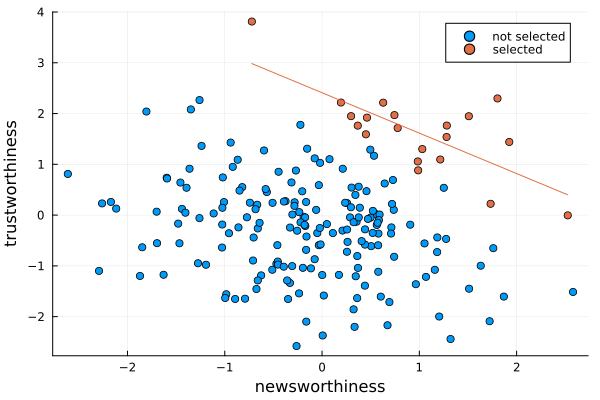

In [3]:
scatter(nw[.!selected], tw[.!selected]; 
    xlab="newsworthiness", ylab="trustworthiness", label="not selected")

Plots.scatter!(nw[selected], tw[selected]; 
    label="selected", smooth=:true)

- Why?
  - Collider Bias

- Without a clear idea of causal model, adding variables to regression
causes hazards.
  - Multicollinearity
  - post treatment bias
  - collider bias

## 6.1 Multicollinearity

- Multicollinear leg
    - What is the value of knowing each leg's length, after already knowing the other leg's length?

In [4]:
Random.seed!(1984)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

In [5]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)[:, [:a, :bl, :br, :σ]]
precis(m6_1_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.8824  0.2733   0.4507   0.8909  1.3256     ▁▁▁▃▆█▅▃▁▁ │
│    bl │ -0.6522  1.7647  -3.4862  -0.6815  2.2087   ▁▁▁▃▅██▇▅▃▁▁ │
│    br │  2.6703  1.7519  -0.1491   2.6971  5.4783   ▁▁▃▄▇██▅▃▁▁▁ │
│     σ │  0.5696  0.0396   0.5122   0.5665  0.6367  ▁▂▃▆██▇▅▃▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


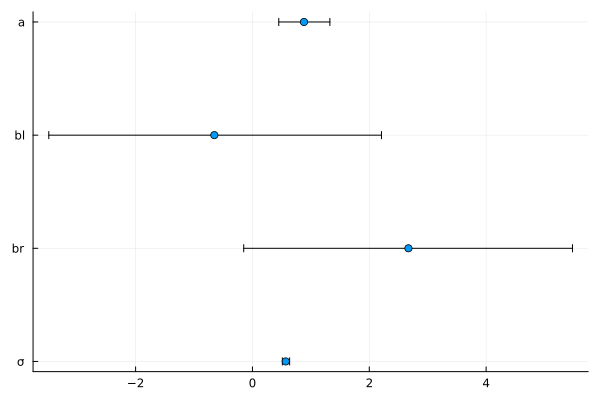

In [6]:
coeftab_plot(m6_1_df)

- You cannot pull apart bl and br.
- But the posterior of sum of bl and br totally makes sense. 

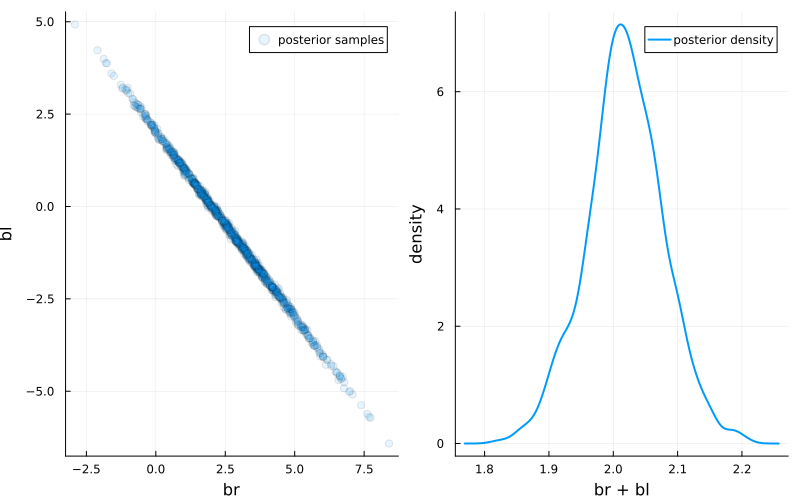

In [7]:
p1 = scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1, xlab="br", ylab="bl",
    label="posterior samples",)

p2 = @df m6_1_df density(:br .+ :bl; lw=2,
    xlab="br + bl", ylab="density",
    label="posterior density",)

plot(p1, p2; layout=(1, 2), size=(800, 500))

## Multicollinear milk

- Data
  -  K: total energy content in primate's milk per gram
  -  F: percent fat
  -  L: percent lactose
  
- Try Bivariate Regressions First

In [8]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

In [9]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)[:, [:a, :bF, :σ]]

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)[:, [:a, :bL, :σ]]

precis(m6_3_df)
precis(m6_4_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │ -0.0005  0.0847  -0.1357  -0.0014  0.1284   ▁▁▂▃▅█▇▆▃▁▁▁ │
│    bF │  0.8539   0.095    0.699   0.8555  1.0105  ▁▁▂▃▆▇█▅▄▂▁▁▁ │
│     σ │  0.4876  0.0671   0.3902   0.4811  0.5993     ▁▃▆█▆▃▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘
┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%    94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ -0.0019  0.0721  -0.1188  0.0007   0.1085   ▁▁▂▅██▅▂▁▁ │
│    bL │ -0.8999  0.0787  -1.0248    -0.9  -0.7764  ▁▁▁▃▅██▅▃▁▁ │
│     σ │  0.4121  0.0618   0.3294  0.4053   0.5291   ▁▃██▄▂▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


- Put F and L in the same regression
- The posterior of F and L are close to 0.
- Why?
  - F, L contain much of the same information.
  - F and L are negatively correlated so strongly so that they are nearly redundant.
  - Either F or L can predict K, but neither helps as much once the other is known!

In [10]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)[:, [:a, :bF, :bL, :σ]]
precis(m6_5_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │ -0.0035  0.0716  -0.1139  -0.0048   0.1097      ▁▁▂▅██▄▂▁▁ │
│    bF │  0.2523  0.2016  -0.0856   0.2558   0.5733        ▁▁▂▆█▄▁▁ │
│    bL │  -0.664  0.2013   -0.998  -0.6622  -0.3442  ▁▁▁▂▃▆██▇▅▃▁▁▁ │
│     σ │  0.4138  0.0584   0.3303   0.4069   0.5122       ▁▃██▅▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


- D: how dense the milk needs to be.

- How to solve the multicollinearity problem?
  - Measure D.
  - Build an evolutionary/economic model.

- Non-Identifiability: data/model not allow estimating the parameters of interest.

- Nature doesn't own us easy inference even if you have the correct model.
    - Posterior may be close to prior.
    - Ask better questions!

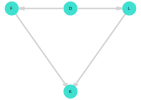

In [11]:
dag = Dagitty.DAG(:D => :L, :D => :F, :L => :K, :F => :K)
drawdag(dag, [1, 0, 1, 2], [0, 0, 1, 0])

## 6.2 Post-Treatment Bias

- **Post-Treatment Bias** is a special **Included Variable Bias**.
  - Blindly tossing variables into the causal salad is never a good idea.

- You want to know the effect of anti-fungal soil treatment on the growth of plants.
  - Outcome: final height (h1)
  - Other variables
    - Initial height (h0)
    - Soil treatment (treatment)
    - Final measure of presence of fungus (fungus)  

In [14]:
Random.seed!(42)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=N ÷ 2)
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d)

┌───────────┬────────────────────────────────────────────────────────┐
│     param │    mean     std    5.5%      50%    94.5%    histogram │
├───────────┼────────────────────────────────────────────────────────┤
│        h0 │    9.78  1.9232  6.8573   9.7095  12.6057   ▁▂▄▅█▅▆▃▁▁ │
│        h1 │ 14.0449  2.6285  9.8383  14.2415   17.818     ▁▂▄▆█▅▁▁ │
│ treatment │     0.5  0.5025     0.0      0.5      1.0  █▁▁▁▁▁▁▁▁▁█ │
│    fungus │    0.28  0.4513     0.0      0.0      1.0  █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴────────────────────────────────────────────────────────┘


- Linear regression model:

$$
\begin{aligned}
h_{1, i} & \sim \operatorname{Normal}\left(\mu_i, \sigma\right) \\
\mu_i & =h_{0, i} \times p \\
p & =\alpha+\beta_T T_i+\beta_F F_i \\
\alpha & \sim \log -\operatorname{Normal}(0,0.25) \\
\beta_T & \sim \operatorname{Normal}(0,0.5) \\
\beta_F & \sim \operatorname{Normal}(0,0.5) \\
\sigma & \sim \operatorname{Exponential}(1)
\end{aligned}
$$

- The treatment is not associated with growth from the posterior.

In [19]:
@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)[:, [:a, :bt, :bf, :σ]]
precis(m6_7_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  1.4733  0.0235   1.4349   1.4738   1.5115      ▁▂▅█▆▃▁▁ │
│    bt │  0.0349  0.0296  -0.0125   0.0356   0.0828    ▁▁▁▄▆██▄▂▁ │
│    bf │ -0.2555  0.0337  -0.3071  -0.2569  -0.2008   ▁▁▂▅██▆▄▂▁▁ │
│     σ │   1.326  0.0913   1.1835   1.3217   1.4823  ▁▁▃▅▇█▆▅▃▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


- Now delete the fungus variable from the model:
$$
\begin{aligned}
h_{1, i} & \sim \operatorname{Normal}\left(\mu_i, \sigma\right) \\
\mu_i & =h_{0, i} \times p \\
p & =\alpha+\beta_T T_i \\
\alpha & \sim \log -\operatorname{Normal}(0,0.25) \\
\beta_T & \sim \operatorname{Normal}(0,0.5) \\
\sigma & \sim \operatorname{Exponential}(1)
\end{aligned}
$$

In [21]:
@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
m6_8_df = DataFrame(m6_8)[:, [:a, :bt, :σ]]
precis(m6_8_df)

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%    histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 1.3529  0.0215  1.3201  1.3525  1.3878     ▁▁▂▅█▆▂▁ │
│    bt │ 0.1422  0.0316  0.0924  0.1422  0.1934  ▁▁▃▆██▆▃▁▁▁ │
│     σ │ 1.6685  0.1206  1.4816  1.6613  1.8683    ▁▂▅█▆▃▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


- F is a post-treatment variable
  - Controlling F, the model asks *Once we know whether a plant developed fungus during growth, does soil treatment matter?*
  - Controlling post-treatment variables can mask treatment itself.
  - However, the two regressions together tell us the mechanism: soil treatment
  helps plants grow by reducing fungus.

- d-Separation
  - some variables on a directed graph are independent of others.

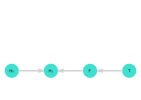

In [45]:
plant_dag = Dagitty.DAG(:H₀ => :H₁, :F => :H₁, :T => :F)
drawdag(plant_dag, [2, 0, 1, 3], [0, 0, 0, 0])

## 6.3 Collider bias

- When you conditional on a collider, it creates a statistical but not necessarily
  causal association between the two parents of the collider.
- If a paper is selected, trustworthiness and newsworthiness are associated.

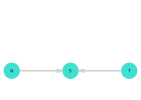

In [46]:
dag = Dagitty.DAG(:T => :S, :N => :S)
drawdag(dag, [0, 1, 2], [0, 0, 0])

- Consider an agent-based model of aging and marriage
    1. Each year, 20 people are born with uniformly distributed happiness values.
    2. Each year, each person ages one year. Happiness does not change.
    3. At age 18, individuals can become married. The odds of marriage each year are
proportional to an individual’s happiness.
    4. Once married, an individual remains married.
    5. After age 65, individuals leave the sample. (They move to Spain.)

┌───────────┬────────────────────────────────────────────────────────┐
│     param │   mean      std     5.5%   50%   94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────┤
│       age │   33.0  18.7689      4.0  33.0    62.0  ▇████████████▂ │
│ happiness │   -0.0   1.2144  -1.7895   0.0  1.7895       █▆█▆▆█▆▆▃ │
│   married │ 0.2854   0.4518      0.0   0.0     1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴────────────────────────────────────────────────────────┘


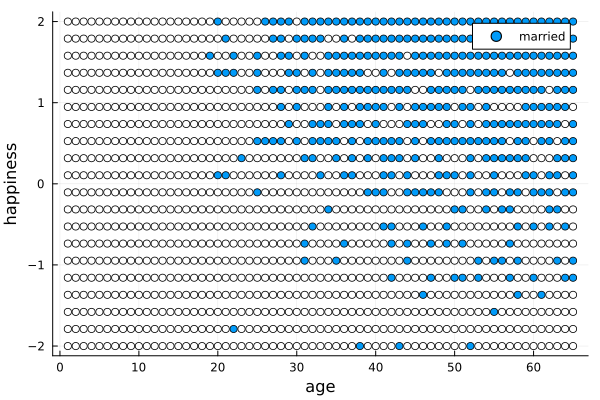

In [49]:
d = sim_happiness(seed=1977, n_years=1000)
precis(d);
d_m = d[d.married .== 1,[:age,:happiness]]
d_u = d[d.married .== 0,[:age,:happiness]]

scatter(d_m.age, d_m.happiness; label="married", xlab="age", ylab="happiness")
scatter!(d_u.age, d_u.happiness; c=:white)

In [50]:
d2 = d[d.age .> 17,:]
d2[!,:A] = @. (d2.age - 18) / (65-18);
d2[!,:mid] = d2.married .+ 1;

In [61]:
@model function model_m6_9(mid, A, happiness)
    a ~ MvNormal([0, 0], 1)
    bA ~ Normal(0, 2)
    μ = a[mid] .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_9 = sample(model_m6_9(d2.mid, d2.A, d2.happiness), NUTS(), 1000)
m6_9_df = DataFrame(m6_9)[:, ["a[1]", "a[2]", "bA", "σ"]]
precis(m6_9_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.1981  0.0613  -0.2966  -0.1991  -0.0992      ▁▁▂▅██▅▂▁ │
│  a[2] │  1.2856  0.0867   1.1456   1.2888    1.419  ▁▁▁▂▄▇██▆▃▁▁▁ │
│    bA │  -0.754  0.1113  -0.9312  -0.7557  -0.5714       ▁▁▂▇█▆▂▁ │
│     σ │  1.0009  0.0224   0.9663   1.0008   1.0369      ▁▁▄██▄▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


In [62]:
@model function model_m6_10(A, happiness)
    a ~ Normal()
    bA ~ Normal(0, 2)
    μ = a .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_10 = sample(model_m6_10(d2.A, d2.happiness), NUTS(), 1000)
m6_10_df = DataFrame(m6_10)[:, ["a", "bA", "σ"]]
precis(m6_10_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%    histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ -0.0004  0.0764  -0.1156  0.0001  0.1194  ▁▁▁▂▆██▅▃▁▁ │
│    bA │  0.0026  0.1326  -0.2094  0.0058  0.2145    ▁▁▂▅██▅▂▁ │
│     σ │   1.216  0.0295   1.1691  1.2152  1.2656   ▁▁▃▆██▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────┘


- Marriage status is a collider.
- Among only blue points, happiness is negatively associated with marriage status.
- What about marriage does impact happiness?
  - Regression doesn't provide the evidence you need to justify the causal claim.
  - You need science (economic model)!

- The haunted DAG

- G: grandparents' education
- P: parents' education
- C: child's education
- U: unobserved neighborhood effects (0: bad, 1: good)

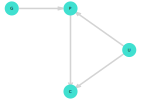

In [74]:
dag = Dagitty.DAG(:G => :P, :P => :C, :U => :P, :U => :C)
drawdag(dag, [1, 0, 1, 2], [0, -2, -2, -1])

In [75]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2;

Random.seed!(6)
U = 2 .* rand(Bernoulli(), N) .- 1
G = rand(Normal(), N)
P = rand(MvNormal(@. b_GP*G + b_U*U))
C = rand(MvNormal(@. b_PC*P + b_GC*G + b_U*U))
d = DataFrame(:C => C, :P => P, :G => G, :U => U);

In [77]:
@model function model_m6_11(P, G, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    μ = @. a + b_PC*P + b_GC*G
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_11 = sample(model_m6_11(d.P, d.G, d.C), NUTS(), 1000)
m6_11_df = DataFrame(m6_11)[:, ["a", "b_PC", "b_GC", "σ"]]
precis(m6_11_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │  0.2101  0.1869  -0.0846  0.2095  0.5088    ▁▂▄▆██▆▄▂▁▁ │
│  b_PC │ -0.0919  0.0945   -0.243  -0.092  0.0661  ▁▁▁▂▃▅██▆▄▂▁▁ │
│  b_GC │  0.4178  0.1941   0.1089  0.4153  0.7281  ▁▁▂▃▅██▆▄▂▁▁▁ │
│     σ │  2.7772  0.1397   2.5548  2.7726  3.0051     ▁▁▃▆██▄▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


- Why grandparent's education has "negative effect" on children's education?
- P is a collider.
- For a parent at a fixed education level, if the parent's education is high,
  the neighborhood is more likely to be bad.

## 6.4 Confronting confounding

- confounding: any context in which the association between an outcome
Y and a predictor of interest X is not the same as it would be,
if we had experimentally determined the values of X

- blocking confounding paths between some predictor X and
some outcome Y is known as shutting the **backdoor**

- Every DAG is built out of four elementary relations 
    - Fork: X <- Z -> Y (control Z, block the path)
    - Pipe: X -> Z -> Y (control Z, block the path)
    - Collider: X -> Z <- Y (control Z, open the path) 
    - Descendant: X -> Z -> Y and Z -> D (control Z, partially open the path) 
  
- Example: Backdoor Waffles 
    - Control S (south), block all three backdoor paths between W and D.

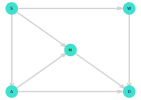

In [90]:
dag = Dagitty.DAG(:S => :A, :S => :M, :A => :M, :S => :W, 
    :A => :D, :M => :D, :W => :D)
drawdag(dag, [1, 3, 2, 1, 3], [2, 2, 1, 0, 0])

- DAG is great.
- It can highlight the danger of using multiple regression without any theory.
- Once you have a model of dynamic system, you don't need DAG. 